<a href="https://colab.research.google.com/github/KingsFrown/ml-course/blob/main/hw02_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-06 12:26:28--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-11-06 12:26:29 (56.2 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [32]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [33]:
next(generate_chunk())

array([[83, 55, 53, ..., 72,  1, 22],
       [83, 36,  1, ..., 63,  1, 58],
       [83, 45,  1, ..., 46, 53, 63],
       ...,
       [83,  0,  0, ..., 53, 62, 60],
       [83, 61, 45, ..., 48, 59,  7],
       [83,  0, 49, ..., 56, 50, 49]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [45]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.gru(input, hidden)
        output = self.decoder(output.view(input.size(0), -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

def random_training_set():
    chunk = next(generate_chunk())
    inp = chunk[:, :-1]
    target = chunk[:, 1:]
    return inp, target

def evaluate(prime_str='a', predict_len=100, temperature=0.8):
    hidden = model.init_hidden(batch_size=1)
    prime_input = [token_to_idx['<sos>']]+[token_to_idx[x] for x in prime_str]
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str)):
        _, hidden = model(torch.tensor([prime_input[p]]).unsqueeze(1), hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(torch.tensor([inp]).unsqueeze(1), hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = idx_to_token[top_i.item()]
        predicted += predicted_char
        inp = token_to_idx[predicted_char]

    return predicted

import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(inp, target):
    inp = torch.tensor(inp, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    hidden = model.init_hidden(batch_size=batch_size)
    model.zero_grad()
    loss = 0

    for c in range(seq_length):
        output, hidden = model(inp[:, c].unsqueeze(1), hidden)
        loss += criterion(output.view(-1, output.size(-1)), target[:, c])

    loss.backward()
    optimizer.step()

    return loss.data.item() / seq_length

n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

model = RNN(num_tokens, hidden_size, num_tokens, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp, target)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(' мой дядя самых честных правил', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 31s (100 5%) 2.1940]
 мой дядя самых честных правил встали, ве
табы в здасть я больный
днаночь.
на серит и струстьяны по лесть.


xxi

моня сача.
придо 

 2s (200 10%) 1.9554]
 мой дядя самых честных правила
его уж не угроский изду недхом!.
он соселово могле
посклеты сумой проской.
он и часто скоровит обр 

 35s (300 15%) 1.8279]
 мой дядя самых честных правилый;
но шали, чуть нос розало.
вохвала в друг альбомой ждерь ужи
замечает быть восошели,
был преждет  

 5s (400 20%) 1.7249]
 мой дядя самых честных правильной
и друг окно любить волненье
и глеби моильной прилетал;
то нашал закведи щадней,
глубравили как  

 36s (500 25%) 1.6600]
 мой дядя самых честных правила:
ожденным сердце смиренною други.



xii

и в шуме на лень нас ужелья:
не шлино так от плухом? – н 

 8s (600 30%) 1.8323]
 мой дядя самых честных правил разлодный,
с как открыла студный казникого,
хоть горязны протило всех
прозатий?. у поэтан;
уж накни 

 38s (700 35%) 1.6261]
 мой дядя самых честных правил.



xx

он сад

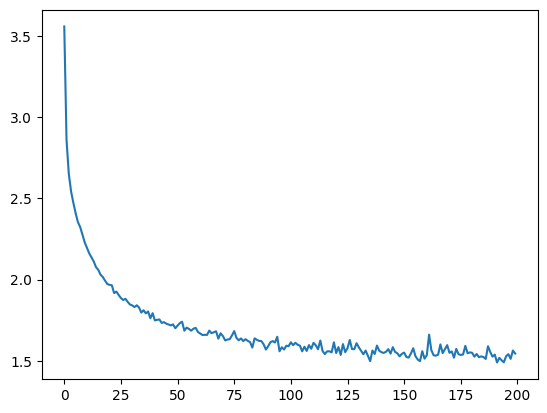

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

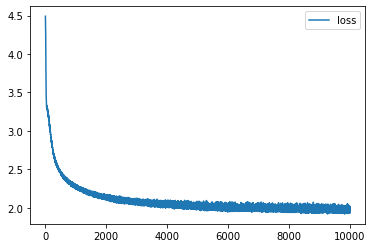

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [47]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.long).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [48]:
print(evaluate(prime_str=' мой дядя самых честных правил', predict_len=500, temperature=0.8))

 мой дядя самых честных правилась
подражают он из милу…» —
«и уж их к нем обаз и зрек
ужела соб венов?



xli

и вам расспеды, что ражденьях
и праводит страстей всё беретил
и тетом тенистью полив моя;
тоской, нежды хочный лесом
и верный наши голос петушки
за поэтожных порти, как ний.
«не говорит. зикокого вестом:
но мученья в ванили.
«сидя ждут он бедавшись —
она стоя навсярка в бена
пора, поэт стелет молодой,
что сердечной розов напела,
упруг может; уж огороды,
заведученный трике,
восторог невольно возок.



xxviii

там про


In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [55]:
seed_phrase = ' мой дядя самых честных правил'

In [57]:
generated_phrases = [evaluate(prime_str=' мой дядя самых честных правил', predict_len=500-30, temperature=0.8) for _ in range(10)]

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [58]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!